<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Feudal_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trello:

### Done
* Minimo viable visual **CHK**
  * particionar matriz gobernador **CHK**
  * particionar matriz señor **CHK**
  * particionar matriz vasallo **CHK**

### To Do

* Generar reglas
  * segun army_value
  * segun loyalties
  * mixtas?
* Hacer funcion generadora de condiciones iniciales
  * generar vasallos
  * asignar algunos vasallos contiguos a señor
  * asignar algunos señores contiguos a gobernador
  * test de que simulacion de matriz fija pueda correr el mismo codigo que matriz aleatoria


In [0]:
import matplotlib
from pylab import *
from IPython import display
import time
import numpy as np

In [0]:
# Parameters

vassal_grid_size = 5 # n x n
lord_grid_size = vassal_grid_size - 2
governor_grid_size = lord_grid_size - 1

initial_army_level = 2 # starts low, [1, 10]
initial_loyalty_value = 1.0 # starts at max, [0.0, 1.0]
army_growth_rate = 0.1
loyalty_decay_rate = 0.01

In [0]:
# Classes


class Vassal:  # Vasallo

  id_ = 0

  def __init__(self, initial_army_level, initial_loyalties_up):
    self.id_ = Vassal.id_
    self.army_value = initial_army_level
    self.loyalties_up = initial_loyalties_up #dict: {L1: loyalty_value1, L2: l_v2}
    Vassal.id_ += 1

  def __repr__(self):
    return "Vassal{} loyalties_up:{}".format(self.id_, self.loyalties_up)


class Lord:  # Señor

  id_ = 0

  def __init__(self, initial_loyalties_up, initial_loyalties_down):
    self.id_ = Lord.id_
    self.loyalties_up = initial_loyalties_up  # dict: {G1: loyalty_value1, G2: l_v2}
    self.loyalties_down = initial_loyalties_down  # dict: {V1: loyalty_value1, V2: l_v2}
    Lord.id_ += 1
    
  def army_value(self):
    """Function to calculate army value of Lord given its loyalties down"""
    pass

  def __repr__(self):
    return "Lord{} loyalties_down:{}".format(self.id_, self.loyalties_down)


class Governor:  # Gobernador

  id_ = 0

  def __init__(self, initial_loyalties_down):
    self.id_ = Governor.id_
    self.loyalties_down = initial_loyalties_down  # dict: {L1: loyalty_value1, L2: l_v2}
    Governor.id_ += 1
    
  def army_value(self):
    """Function to calculate army value of Governor given its loyalties down"""
    pass

  def __repr__(self):
    return "Governor{} loyalties_down:{}".format(self.id_, self.loyalties_down)

In [0]:
#Auxiliar functions

def connect_down(A, B, value=initial_loyalty_value):
  """Connects A down to B. A will have a loyalties_down pointing to B.
  B will have a loyalties_up pointing to A"""
  A.loyalties_down[B.id_] = value
  B.loyalties_up[A.id_] = value

def connect_all():
  pass

def find_lord_of_vassal(vassal):
  """ Given a vassal object, returns the lord object connected with him """
  lord_id = list(vassal.loyalties_up.keys())[0] #id of first lord connected
  target_lord = None
  for lord in all_lords:
    if lord.id_ == lord_id:
      target_lord = lord
      return target_lord
  if target_lord == None:
    raise ValueError("Vassal's lord not present in all_lords list")

def find_governor_of_vassal(vassal):
  """ Given a vassal object, returns the governor object connected with him through a lord"""
  lord = find_lord_of_vassal(vassal)
  governor_id = list(lord.loyalties_up.keys())[0]
  target_governor = None
  for governor in all_governors:
    if governor.id_ == governor_id:
      target_governor = governor
      return target_governor
  if target_governor == None:
    raise ValueError("Vassal's governor not present in all_governors list")


In [0]:
# backend

def initialize():
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig, all_vassals, all_lords, all_governors


    #initialize vassal level
    vassal_config = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(initial_army_level, {})))
    all_vassals = []

    for x in range(vassal_grid_size):
      for y in range(vassal_grid_size):
        new_vassal = Vassal(initial_army_level, {})
        vassal_config[x, y] = new_vassal
        all_vassals.append(new_vassal)

    vassal_nextconfig = np.zeros([vassal_grid_size, vassal_grid_size])

    #initialize lord level
    lord_config = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord({}, {})))
    all_lords = []

    for x in range(lord_grid_size):
      for y in range(lord_grid_size):
        new_lord = Lord({}, {})
        lord_config[x, y] = new_lord
        all_lords.append(new_lord)

    lord_nextconfig = np.zeros([lord_grid_size, lord_grid_size])

    #initialize governor level
    governor_config = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor({})))
    all_governors = []

    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        new_governor = Governor({})
        governor_config[x, y] = new_governor
        all_governors.append(new_governor)

    governor_nextconfig = np.zeros([governor_grid_size, governor_grid_size])

    #connect all levels (random initial condition (WIP))
    #for x in range(governor_grid_size):
    #  for y in range(governor_grid_size):
    #    connect_down(governor_config[x,y], lord_config[x, y])
    #    connect_down(governor_config[x,y], lord_config[x+1, y+1]) #connections shouldnt be made in diagonals purely
    #
    #for x in range(lord_grid_size):
    #  for y in range(lord_grid_size):
    #    connect_down(lord_config[x,y], vassal_config[x, y])
    #    connect_down(lord_config[x,y], vassal_config[x+1, y+1]) #connections shouldnt be made in diagonals purely
    
    #connect all levels (deterministic initial condition)
    #connect govs
    #1st gov
    connect_down(governor_config[0,0], lord_config[0, 0])
    connect_down(governor_config[0,0], lord_config[1, 0])
    #2nd gov
    connect_down(governor_config[0,1], lord_config[0, 1])
    connect_down(governor_config[0,1], lord_config[0, 2])
    #3rd gov
    connect_down(governor_config[1,0], lord_config[1, 1])
    connect_down(governor_config[1,0], lord_config[1, 2])
    connect_down(governor_config[1,0], lord_config[2, 2])
    #4th gov
    connect_down(governor_config[1,1], lord_config[2, 0])
    connect_down(governor_config[1,1], lord_config[2, 1])
    
    #connect lords
    #1st lord
    connect_down(lord_config[0,0], vassal_config[0, 0])
    connect_down(lord_config[0,0], vassal_config[1, 0])
    connect_down(lord_config[0,0], vassal_config[0, 1])
    #2do lord
    connect_down(lord_config[0,1], vassal_config[0, 2])
    connect_down(lord_config[0,1], vassal_config[1, 2])
    connect_down(lord_config[0,1], vassal_config[0, 3])
    #3rd lord
    connect_down(lord_config[0,2], vassal_config[1, 3])
    connect_down(lord_config[0,2], vassal_config[0, 4])
    connect_down(lord_config[0,2], vassal_config[1, 4])
    connect_down(lord_config[0,2], vassal_config[2, 4])
    #4th lord
    connect_down(lord_config[1,0], vassal_config[2, 0])
    connect_down(lord_config[1,0], vassal_config[1, 1])
    connect_down(lord_config[1,0], vassal_config[2, 1])
    #5th lord
    connect_down(lord_config[1,1], vassal_config[2, 2])
    connect_down(lord_config[1,1], vassal_config[3, 2])
    connect_down(lord_config[1,1], vassal_config[2, 3])
    #6th lord
    connect_down(lord_config[1,2], vassal_config[3, 3])
    connect_down(lord_config[1,2], vassal_config[3, 4])
    connect_down(lord_config[1,2], vassal_config[4, 4])
    #7th lord
    connect_down(lord_config[2,0], vassal_config[3, 0])
    connect_down(lord_config[2,0], vassal_config[4, 0])
    #8th lord
    connect_down(lord_config[2,1], vassal_config[3, 1])
    connect_down(lord_config[2,1], vassal_config[4, 1])
    #9th lord
    connect_down(lord_config[2,2], vassal_config[4, 2])
    connect_down(lord_config[2,2], vassal_config[4, 3])


    print("Vassal Initial Config:")
    print(vassal_config)
    print("")
    print("Lord Initial Config:")
    print(lord_config)
    print("")
    print("Governor Initial Config:")
    print(governor_config)
    print("")
########################################################################################################
# 1st rule should be attack lowest neighbour if sum(neighbours army values) <= self.armyvalue * amount of neighbours (just a thought)
# 2nd rule should be based on loyalties
#2-3 rules per param

def observe(ca_level="lord", color_map="viridis"):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig, all_vassals, all_lords, all_governors
    cla()
    if ca_level == "vassal":  # plot vassal level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = vassal_config[x,y].id_ #cambia instancia por id
      imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

    if ca_level == "lord":  # plot lord level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = find_lord_of_vassal(vassal_config[x,y]).id_ #list(vassal_config[x,y].loyalties_up.keys())[0] #cambia instancia de vassal por id del primer lord conectado
      imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

    if ca_level == "governor":  # plot governor level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = find_governor_of_vassal(vassal_config[x,y]).id_ #cambia instancia de vassal por id del primer lord conectado
      imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

def update():
    global config, nextconfig

    #iterate through grid
    for x in range(n):
        for y in range(n):
            count = 0
            central_value = config[x % n, y % n]

            if central_value != 0: #this cell is only excitable if it's in state 0
              #if it's not excitable, we just advance in state and skip neighbourhood check
              if central_value + 1 <= k:
                nextconfig[x, y] = central_value + 1
              else:
                nextconfig[x, y] = 0
              continue

            #cell is excitable, iterate through (x,y)'s moore neighbourhood
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0: #dont count central cell (outer totalistic)
                      continue
                    # % n makes it cross frontiers
                    count += 1 if config[(x + dx) % n, (y + dy) % n] == 1 else 0  # we add to counter only if this neighbour is excited

            nextconfig[x, y] = 1 if np.random.uniform(0, 1) <= (count/4) else 0 #estochastic excitement condition
            #nextconfig[x, y] = 1 if count > 1 else 0 #deterministic excitement condition

    config, nextconfig = nextconfig, config

Vassal Initial Config:
[[Vassal27 loyalties_up:{11: 1.0} Vassal28 loyalties_up:{11: 1.0}
  Vassal29 loyalties_up:{12: 1.0} Vassal30 loyalties_up:{12: 1.0}
  Vassal31 loyalties_up:{13: 1.0}]
 [Vassal32 loyalties_up:{11: 1.0} Vassal33 loyalties_up:{14: 1.0}
  Vassal34 loyalties_up:{12: 1.0} Vassal35 loyalties_up:{13: 1.0}
  Vassal36 loyalties_up:{13: 1.0}]
 [Vassal37 loyalties_up:{14: 1.0} Vassal38 loyalties_up:{14: 1.0}
  Vassal39 loyalties_up:{15: 1.0} Vassal40 loyalties_up:{15: 1.0}
  Vassal41 loyalties_up:{13: 1.0}]
 [Vassal42 loyalties_up:{17: 1.0} Vassal43 loyalties_up:{18: 1.0}
  Vassal44 loyalties_up:{15: 1.0} Vassal45 loyalties_up:{16: 1.0}
  Vassal46 loyalties_up:{16: 1.0}]
 [Vassal47 loyalties_up:{17: 1.0} Vassal48 loyalties_up:{18: 1.0}
  Vassal49 loyalties_up:{19: 1.0} Vassal50 loyalties_up:{19: 1.0}
  Vassal51 loyalties_up:{16: 1.0}]]

Lord Initial Config:
[[Lord11 loyalties_down:{27: 1.0, 32: 1.0, 28: 1.0}
  Lord12 loyalties_down:{29: 1.0, 34: 1.0, 30: 1.0}
  Lord13 loyalt

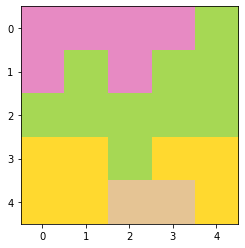

In [7]:
#main

# Simulate and plot results
initialize()
observe("lord", "Set2")
#for t in range(1000):
#    update()
#    observe('twilight_shifted')
#    display.clear_output(wait=True)
#    display.display(gcf())
#    time.sleep(0.1)
#    plt.close()
#plt.show()